In [2]:
# improting useful libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import datetime as dt

In [3]:
# loading the dataset
df = pd.read_csv('train.csv')
df

,date,store,item,sales
0,2013-01-01,1,1,13
1,2013-01-02,1,1,11
2,2013-01-03,1,1,14
3,2013-01-04,1,1,13
4,2013-01-05,1,1,10
...,...,...,...,...
912995,2017-12-27,10,50,63
912996,2017-12-28,10,50,59
912997,2017-12-29,10,50,74
912998,2017-12-30,10,50,62


In [ ]:
#     ----- checking and data cleaning -----

print(df.duplicated().sum())
df = df.drop_duplicates()
print(df.duplicated().sum())

0
0


In [5]:
# changing date column to datetime type and setting it as index
df['date'] = pd.to_datetime(df['date'])
df.set_index('date', inplace=True)
df

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [6]:
# sorting the dataframe by store, item, and then by date
df = df.sort_values(["store", "item", "date"])
df

,store,item,sales
date,,,
2013-01-01,1,1,13
2013-01-02,1,1,11
2013-01-03,1,1,14
2013-01-04,1,1,13
2013-01-05,1,1,10
...,...,...,...
2017-12-27,10,50,63
2017-12-28,10,50,59
2017-12-29,10,50,74


In [7]:
df.isnull().sum()

store    0
item     0
sales    0
dtype: int64

In [8]:
# checking if there are any missing dates
start_date = df.index.min()
end_date = df.index.max()

full_date_range = pd.date_range(
    start=start_date,
    end=end_date,
    freq="D"
)
missing_dates = full_date_range.difference(df.index)
len(missing_dates)

0

In [9]:
df.groupby(["date", "store", "item"]).size().value_counts()

1    913000
Name: count, dtype: int64

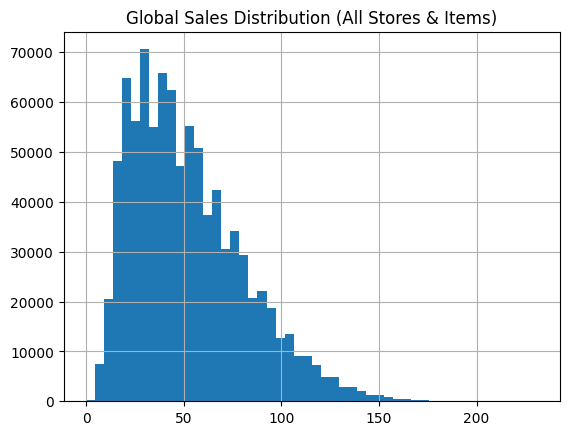

In [10]:
df["sales"].hist(bins=50)
plt.title("Global Sales Distribution (All Stores & Items)")
plt.show()

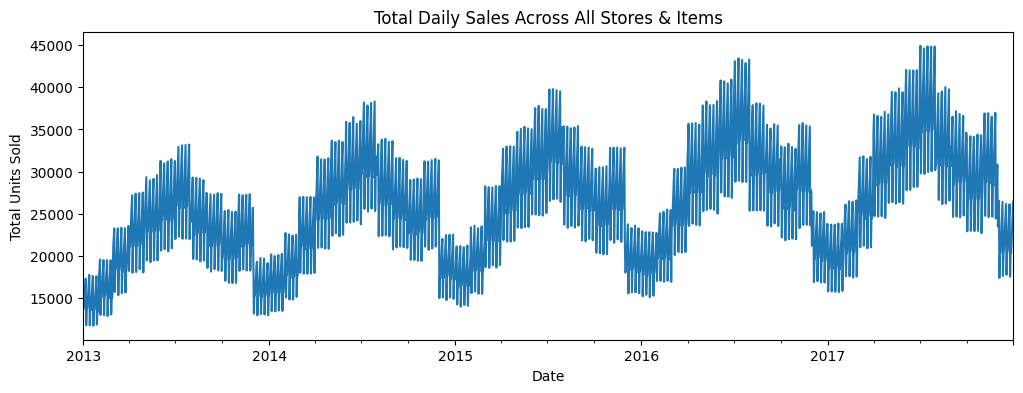

In [11]:
daily_total_sales = df.groupby("date")["sales"].sum()

daily_total_sales.plot(figsize=(12,4))
plt.title("Total Daily Sales Across All Stores & Items")
plt.xlabel("Date")
plt.ylabel("Total Units Sold")
plt.show()

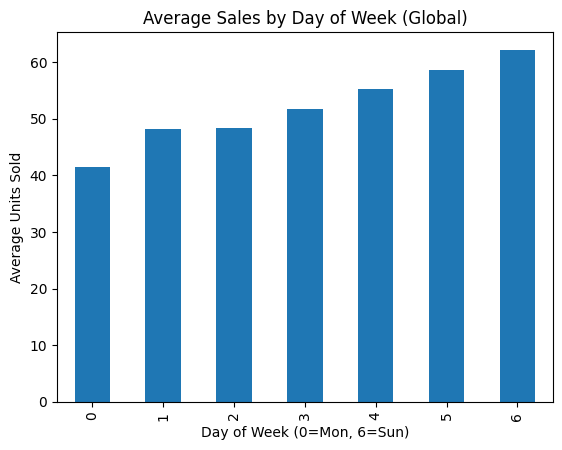

In [12]:
df["dayofweek"] = df.index.dayofweek

df.groupby("dayofweek")["sales"].mean().plot(kind="bar")
plt.title("Average Sales by Day of Week (Global)")
plt.xlabel("Day of Week (0=Mon, 6=Sun)")
plt.ylabel("Average Units Sold")
plt.show()

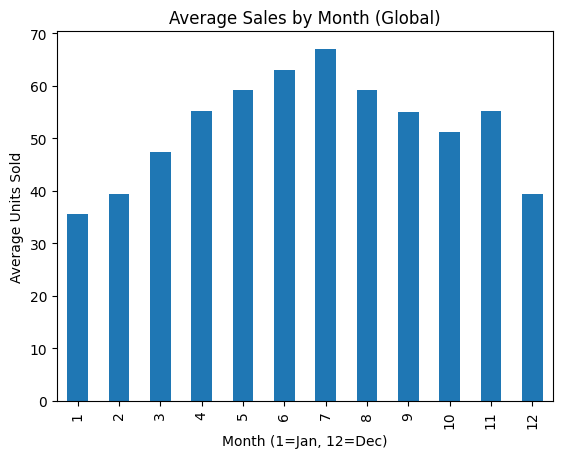

In [13]:
df["month"] = df.index.month

df.groupby("month")["sales"].mean().plot(kind="bar")
plt.title("Average Sales by Month (Global)")
plt.xlabel("Month (1=Jan, 12=Dec)")
plt.ylabel("Average Units Sold")
plt.show()

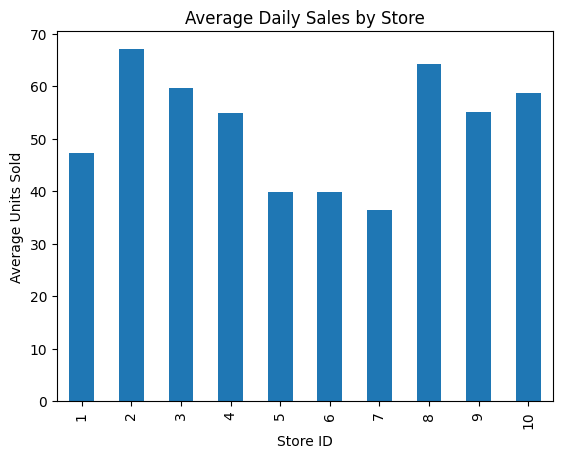

In [14]:
df.groupby("store")["sales"].mean().plot(kind="bar")
plt.title("Average Daily Sales by Store")
plt.xlabel("Store ID")
plt.ylabel("Average Units Sold")
plt.show()

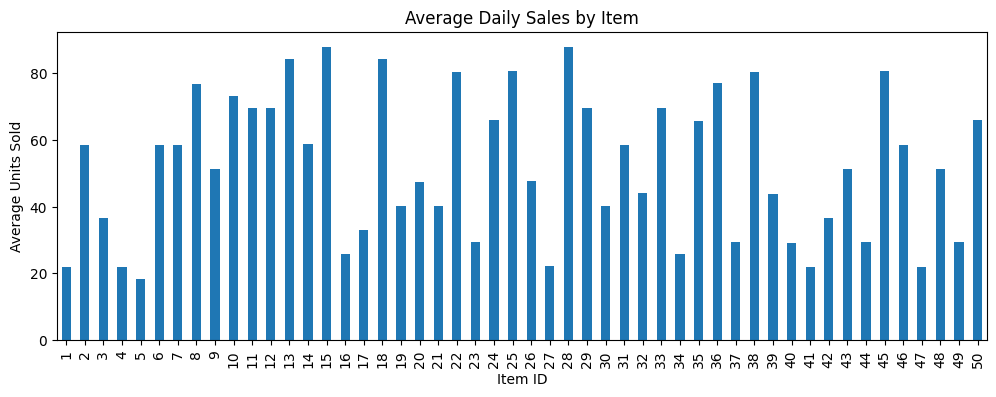

In [15]:
df.groupby("item")["sales"].mean().plot(kind="bar", figsize=(12,4))
plt.title("Average Daily Sales by Item")
plt.xlabel("Item ID")
plt.ylabel("Average Units Sold")
plt.show()

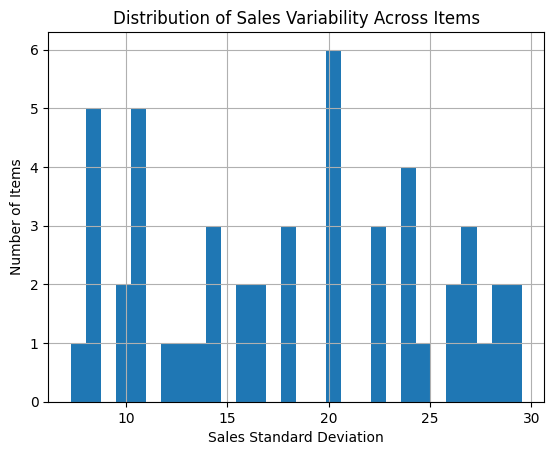

In [16]:
df.groupby("item")["sales"].std().hist(bins=30)
plt.title("Distribution of Sales Variability Across Items")
plt.xlabel("Sales Standard Deviation")
plt.ylabel("Number of Items")
plt.show()

In [17]:
# Create the skeleton dataframe
all_dates = pd.date_range(start=df.index.min(), end=df.index.max(), freq='D')
all_stores = df['store'].unique()
all_items = df['item'].unique()

# Create all combinations
grid = pd.MultiIndex.from_product([all_dates, all_stores, all_items], names=['date', 'store', 'item'])
grid = pd.DataFrame(index=grid).reset_index()

# Merge original data into the grid
# We reset_index() on df to make 'date' a column again for the merge
df_final = pd.merge(grid, df.reset_index(), on=['date', 'store', 'item'], how='left')

# Fill missing sales with 0
df_final['sales'] = df_final['sales'].fillna(0)

print(f"Original shape: {df.shape}, Expanded shape: {df_final.shape}")

df_final['sales'] = df_final['sales'].astype(np.float32)
df_final['store'] = df_final['store'].astype(np.int16)
df_final['item'] = df_final['item'].astype(np.int16)

# Sort again to ensure time flows correctly for feature engineering
df_final = df_final.sort_values(['store', 'item', 'date']).reset_index(drop=True)

Original shape: (913000, 5), Expanded shape: (913000, 6)


In [21]:
df_final["date"].dtype

dtype('<M8[ns]')

In [ ]:
#        ---- feature engineering start ----
# lag features
lags = [1, 7, 14, 28]
for lag in lags:
    df_final[f"lag_{lag}"] = (
        df_final
        .groupby(["store", "item"])["sales"]
        .shift(lag)
    )

In [24]:
df_final.head()

,date,store,item,sales,dayofweek,month,lag_1,lag_7,lag_14,lag_28
0,2013-01-01,1,1,13.0,1,1,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,2,1,13.0,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,3,1,11.0,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,4,1,14.0,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,5,1,13.0,NaN,NaN,NaN


In [28]:
df_final[(df_final["store"] == 1) & (df_final["item"] == 1)].head(15)


,date,store,item,sales,dayofweek,month,lag_1,lag_7,lag_14,lag_28
0,2013-01-01,1,1,13.0,1,1,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,2,1,13.0,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,3,1,11.0,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,4,1,14.0,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,5,1,13.0,NaN,NaN,NaN
5,2013-01-06,1,1,12.0,6,1,10.0,NaN,NaN,NaN
6,2013-01-07,1,1,10.0,0,1,12.0,NaN,NaN,NaN
7,2013-01-08,1,1,9.0,1,1,10.0,13.0,NaN,NaN
8,2013-01-09,1,1,12.0,2,1,9.0,11.0,NaN,NaN
9,2013-01-10,1,1,9.0,3,1,12.0,14.0,NaN,NaN


In [29]:
df_final[(df_final["store"] == 1) & (df_final["item"] == 1)][
    ["date", "sales", "lag_1", "lag_7"]
].head(15)

,date,sales,lag_1,lag_7
0,2013-01-01,13.0,NaN,NaN
1,2013-01-02,11.0,13.0,NaN
2,2013-01-03,14.0,11.0,NaN
3,2013-01-04,13.0,14.0,NaN
4,2013-01-05,10.0,13.0,NaN
5,2013-01-06,12.0,10.0,NaN
6,2013-01-07,10.0,12.0,NaN
7,2013-01-08,9.0,10.0,13.0
8,2013-01-09,12.0,9.0,11.0
9,2013-01-10,9.0,12.0,14.0


In [30]:
# rolling mean features

df_final["roll_mean_7"] = (
    df_final
    .groupby(["store", "item"])["sales"]
    .shift(1)
    .rolling(7)
    .mean()
)

df_final["roll_mean_14"] = (
    df_final
    .groupby(["store", "item"])["sales"]
    .shift(1)
    .rolling(14)
    .mean()
)

In [33]:
# rollong std features

df_final["roll_std_7"] = (
    df_final
    .groupby(["store", "item"])["sales"]
    .shift(1)
    .rolling(7)
    .std()
)

df_final[(df_final["store"] == 1) & (df_final["item"] == 1)][
    ["date", "sales", "lag_7", "roll_mean_7", "roll_std_7"]
].tail(10)

,date,sales,lag_7,roll_mean_7,roll_std_7
1816,2017-12-22,6.0,16.0,15.285714,4.820591
1817,2017-12-23,18.0,15.0,13.857143,5.928141
1818,2017-12-24,19.0,22.0,14.285714,6.129554
1819,2017-12-25,13.0,19.0,13.857143,5.580579
1820,2017-12-26,16.0,7.0,13.000000,5.099020
1821,2017-12-27,14.0,16.0,14.285714,4.423961
1822,2017-12-28,19.0,12.0,14.000000,4.358899
1823,2017-12-29,15.0,6.0,15.000000,4.618802
1824,2017-12-30,27.0,18.0,16.285714,2.429972
1825,2017-12-31,23.0,19.0,17.571429,4.755949


In [35]:
df_final.head()

,date,store,item,sales,dayofweek,month,lag_1,lag_7,lag_14,lag_28,roll_mean_7,roll_mean_14,roll_std_7
0,2013-01-01,1,1,13.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2013-01-02,1,1,11.0,2,1,13.0,NaN,NaN,NaN,NaN,NaN,NaN
2,2013-01-03,1,1,14.0,3,1,11.0,NaN,NaN,NaN,NaN,NaN,NaN
3,2013-01-04,1,1,13.0,4,1,14.0,NaN,NaN,NaN,NaN,NaN,NaN
4,2013-01-05,1,1,10.0,5,1,13.0,NaN,NaN,NaN,NaN,NaN,NaN


In [38]:
#     ----- calendar features  -----
df_final['day_of_month'] = df_final['date'].dt.day
df_final['year'] = df_final['date'].dt.year
df_final['week_of_year'] = df_final['date'].dt.isocalendar().week.astype(int)

df_final['is_weekend'] = (df_final['dayofweek'] >= 5).astype(int)
df_final['is_month_start'] = df_final['date'].dt.is_month_start.astype(int)
df_final['is_month_end'] = df_final['date'].dt.is_month_end.astype(int)
df_final['is_holiday_season'] = df_final['month'].isin([11, 12]).astype(int)

In [39]:
df_final.head()

,date,store,item,sales,dayofweek,month,lag_1,lag_7,lag_14,lag_28,roll_mean_7,roll_mean_14,roll_std_7,day_of_month,year,week_of_year,is_weekend,is_month_start,is_month_end,is_holiday_season
0,2013-01-01,1,1,13.0,1,1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1,2013,1,0,1,0,0
1,2013-01-02,1,1,11.0,2,1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,2,2013,1,0,0,0,0
2,2013-01-03,1,1,14.0,3,1,11.0,NaN,NaN,NaN,NaN,NaN,NaN,3,2013,1,0,0,0,0
3,2013-01-04,1,1,13.0,4,1,14.0,NaN,NaN,NaN,NaN,NaN,NaN,4,2013,1,0,0,0,0
4,2013-01-05,1,1,10.0,5,1,13.0,NaN,NaN,NaN,NaN,NaN,NaN,5,2013,1,1,0,0,0
